# Data Import

[Word2Vec](https://pathmind.com/wiki/word2vec)

[More Word2Vec](https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XrtY6xNKiRs)

# Load in datasets

In [316]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import numpy as n
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

In [413]:
# bring in each data set for each state

cali = pd.read_csv('../data/scrape_dm_cali.csv')

mich = pd.read_csv('../data/scrape_dm_mich.csv')

ny = pd.read_csv('../data/scrape_dm_ny.csv')

ohio = pd.read_csv('../data/scrape_dm_ohio.csv')

texas = pd.read_csv('../data/scrape_dm_texas.csv')

# concatenate datasets to one dataframe 
tweets = pd.concat([cali, mich, ny, ohio, texas])

tweets.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start
0,710245730590404608,TTWN SF Bay Area,Power outage in Cupertino #BayArea #Traffic ht...,2016-03-16 23:25:52,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
1,708811502241734656,San Jose Now,WEATHER ALERT: Flash flood watch in Bay Area a...,2016-03-13 00:26:45,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
2,706856719733776384,San Jose Now,Power outages:30 in San Francisco154 on Penins...,2016-03-07 14:59:09,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
3,726876023573204993,San Jose Now,Power outage in Fremont. Several intersections...,2016-05-01 20:48:43,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
4,724681945095888897,San Jose Now,"East Bay power outages also affects BART, UC B...",2016-04-25 19:30:14,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01


## Data Cleaning

In [414]:
tweets.shape

(20100, 10)

In [415]:
# drop duplicates 
tweets.drop_duplicates(inplace=True)

In [416]:
tweets.shape

(16913, 10)

In [419]:
# reset index 
tweets.reset_index(inplace= True, drop = True)

In [420]:
tweets.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start
0,710245730590404608,TTWN SF Bay Area,Power outage in Cupertino #BayArea #Traffic ht...,2016-03-16 23:25:52,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
1,708811502241734656,San Jose Now,WEATHER ALERT: Flash flood watch in Bay Area a...,2016-03-13 00:26:45,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
2,706856719733776384,San Jose Now,Power outages:30 in San Francisco154 on Penins...,2016-03-07 14:59:09,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
3,726876023573204993,San Jose Now,Power outage in Fremont. Several intersections...,2016-05-01 20:48:43,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01
4,724681945095888897,San Jose Now,"East Bay power outages also affects BART, UC B...",2016-04-25 19:30:14,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01


In [421]:
tweets.isnull().sum()

tweet_id       0
username       0
text           0
tweet_date     0
search_term    0
city           0
lat            0
long           0
radius         0
query_start    0
dtype: int64

No null values

## Function to clean tweets & usernames

In [422]:
def clean_str(string):
    string = string.lower()
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    string = re.sub(url_pattern, ' ', string)
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]+", "", string)
    string = re.sub(r'[^\w\s]','', string)    
    
    return string.strip()

In [423]:
tweets['text'] = tweets['text'].map(clean_str) # clean tweets
tweets['username'] = tweets['username'].map(clean_str) # clean username

In [424]:
# making new column with username + tweet
tweets['name_and_tweet'] = tweets['username'] + " " +tweets['text']

## Word2Vec Model

In [425]:
# turning cleaned tweets into list of lists

def tweet_to_words(tweets):
    # empty list of tweets
    list_of_tweets = []
    
    # make tweet into list of words
    for tweet in tweets:
        tweet = tweet.split()
    
        # list of stop words
        stops = ['los','angeles','san','diego','jose','columbus','cleveland',
             'cincinatti','detroit','ann','arbor','warren','new','york',
             'ny','buffalo','rochester','michigan','california','ohio','texas',
            'st','amc','scott','schudlich','finnished','de','antonio','la','houston',
                 'dallas', 'santa', 'ana', 'clara', 'grand', 'rapids', 'kearny','mesa',
                'peticolas','christmas']
    
        # Remove stopwords.
        meaningful_tweet = [w for w in tweet if not w in stops]
    
        # add tweet to big list
        list_of_tweets.append(meaningful_tweet)

    return list_of_tweets

Stop words list was created through an iterative process with the Word2Vec model. We looked at the most closely associated words to our `search_terms` and took out words that were not relevant or associated to a different meaning of the word.

For example, we took out all words associated with the cities/locations, because they didn't directly impact the meaning of a tweet and its discussion of a power outage. 

Another example is the word _peticolas_, which we learned is a brewery in Dallas, Texas, that makes `light` and `dark` beers, and a drink called `turn out the lights`. Thus, _Peticolas_ was throwing off our model. 

We made each tweet into a list of _meaningful_ words in that tweet, meaning the words were not found in our stop words list `stops`. 

In [426]:
# making corpus
corpus = tweet_to_words(tweets['name_and_tweet'])

In [427]:
 # Train a model! 
model = Word2Vec(corpus,      # Corpus of data.
                  size=150,    # How many dimensions do you want in your word vector?
                  window=5,    # How many "context words" do you want?
                  min_count=3, # Ignores words below this threshold.
                  sg=1,        # SG = 1 uses SkipGram
                  workers=4)   # Number of "worker threads" to use (parallelizes process).

## Words most and least associated with `search_terms`

For each of our `seach_terms`, including the utility companies,  we looked at the top 10 most associated words and top 10 least associated words. Associated is determined by cosine similarity, where a value of 1 means completely the same, a value of -1 means completely the opposite and a value of 0 means one words will give you no information on the other word. We determined the most associated words to be those with the highest cosine similarities, and the least associated words to be those with cosine similarities closest to 0, giving us no information about that word.  

Some examples of those most and least associated words are below. 

In [428]:
# most similar to 'outages'
model.most_similar('outages')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('outage', 0.786902904510498),
 ('customers', 0.7775238156318665),
 ('crews', 0.7659372687339783),
 ('restoration', 0.7632731795310974),
 ('areas', 0.7600740194320679),
 ('without', 0.7590598464012146),
 ('winds', 0.7544023990631104),
 ('currently', 0.7533421516418457),
 ('lines', 0.75185227394104),
 ('residents', 0.7508839964866638)]

In [429]:
# most similar to 'interruption'
model.most_similar('interruption')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('centerpoint', 0.9269407391548157),
 ('report', 0.9217776656150818),
 ('customer', 0.9210830926895142),
 ('consumers', 0.918605387210846),
 ('electricity', 0.918485701084137),
 ('service', 0.9180868864059448),
 ('cps', 0.9166773557662964),
 ('route', 0.9159972667694092),
 ('inconvenience', 0.9128239750862122),
 ('electrical', 0.9073225855827332)]

In [430]:
# least associated with 'coned' (ConEdison)
model.most_similar(positive = 'coned',negative = 'coned')

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('when', 0.09784715622663498),
 ('family', 0.08582960069179535),
 ('thank', 0.08202363550662994),
 ('you', 0.07735006511211395),
 ('friends', 0.07409873604774475),
 ('lets', 0.06742234528064728),
 ('shine', 0.06026162952184677),
 ('power', 0.053566791117191315),
 ('heart', 0.05333944410085678),
 ('safe', 0.05069771409034729)]

Through this process we were able to compile a list of the most associated words with our `search_terms`, as well as a list of those with cosine similarities close to 0,  to help us determine how related to power outages a tweet would be. Those lists are below.

In [431]:
associated = ['outages', 'poweroutage','outage','poweroutages','area','failure','dte',
              'transformer','caused','update','storm','customers','without','lines',
              'crews','affecting','experiencing','restoration','reports','area','ladwp',
              'clepublicpower','hurricaneseason','dispatching','interruption','report',
              'service','centerpoint','inconvenience','cps','customer','consumers',
              'prevent','conditions','fire','explosion','pole','accident','caused',
              'electricity','grid','information','pge','aep','currently','planned',
              'reported','widespread','wind','updates','estimates','according',
             'utility','areas','sdge','warnings','capacity','thousand','disabled',
              'covid','regional','impacted','resolve','determine','phones','homes',
             'numerous','resume','forecasted','reopen','shutdown','blackout','scheduled',
             'reported','partial','significant','causes','delayed','temporary',
             'unplanned','shortly','utilities','safety','homes','route','businesses',
             'national','pge','coned','rge','dukeenergy','consumersenergy',
              'nationalgrid','wildfires','info','electrical']

non_associated = ['electric','martin','darkness','so','luther','power','great',
                  'sure','trump','she','of','or','by','day','up','if','please',
                  'for','their','your','massive','major','parts','by','metro',
                  'that','south','any','widespread','closet','poshmark','car',
                 'bike','use','phone','guitar','room','off','play','gas','off',
                 'use','out','can','its','some','hall','are','im','do','da','cannot',
                   'cut','own','life','hands','wash','miles','care','family',
                   'had','person','bill','matter','trust','so','give','realdonaldtrump',
                   'absolutely','reason','thats','am','were','be','theyre','youre',
                    'was','traffic','both','link','lightsout','video','song','click',
                    'bio','bubblelife','mothers','center','zoo','day','cuts','an',
                   'festival', 'about','scooter','ready','saw','turn','ford','roberts',
                    'william','mary','discount','code','kick','grab','entire','body',
                   'myself','heating','john']

### Code to check for words in tweets (we should probably delete this part later but will keep here just in case)

In [432]:
for tweet in tweets['name_and_tweet']:
    if 'testingstuff' in tweet:
        print(tweet)

## Outage Sentiment Analysis

We have built a function that calculates the _outage sentiment_ for each tweets. The function will count how many associated words are found in the tweet and returns a percentage. Tweets with an outage sentiment of 1 are estimated to be completely related to power outages, where tweets with outage sentiments of 0 are estimated to be not related to power outages at all. 

The tweets run through a second stop words list here that is based on the English stop words list from `nltk`. 

In [433]:
## THIS ANALYSIS DIDN'T WORK! KEEPING IT HERE JUST IN CASE!
#
## code based off of simple_sentiment() from Global Lesson, 5.03 NLP I
#
#def outage_sentiment(tweet):
#    
#    # associated word list
#    associated = ['outages', 'poweroutage','outage','poweroutages','area','failure','dte',
#              'transformer','caused','update','storm','customers','without','lines',
#              'crews','affecting','experiencing','restoration','reports','area','ladwp',
#              'clepublicpower','hurricaneseason','dispatching','interruption','report',
#              'service','centerpoint','inconvenience','cps','customer','consumers',
#              'prevent','conditions','fire','explosion','pole','accident','caused',
#              'electricity','grid','information','pge','aep','currently','planned',
#              'reported','widespread','wind','updates','estimates','according',
#             'utility','areas','sdge','warnings','capacity','thousand','disabled',
#              'covid','regional','impacted','resolve','determine','phones','homes',
#             'numerous','resume','forecasted','reopen','shutdown','blackout','scheduled',
#             'reported','partial','significant','causes','delayed','temporary',
#             'unplanned','shortly','utilities','safety','homes','route','businesses',
#             'national','pge','coned','rge','dukeenergy','consumersenergy',
#              'nationalgrid','wildfires','info','electrical']
#    
#    # non-associated word list
#    non_associated = ['electric','martin','darkness','so','luther','power','great',
#                  'sure','trump','she','of','or','by','day','up','if','please',
#                  'for','their','your','massive','major','parts','by','metro',
#                  'that','south','any','widespread','closet','poshmark','car',
#                 'bike','use','phone','guitar','room','off','play','gas','off',
#                 'use','out','can','its','some','hall','are','im','do','da','cannot',
#                   'cut','own','life','hands','wash','miles','care','family',
#                   'had','person','bill','matter','trust','so','give','realdonaldtrump',
#                   'absolutely','reason','thats','am','were','be','theyre','youre',
#                    'was','traffic','both','link','lightsout','video','song','click',
#                    'bio','bubblelife','mothers','center','zoo','day','cuts','an',
#                   'festival', 'about','scooter','ready','saw','turn','ford','roberts',
#                    'william','mary','discount','code','kick','grab','entire','body',
#                   'myself','heating','john']
#    
#    # Count "associated" words.
#    associated_count = len([w for w in tweet if w in associated])
#    
#    # Count "non-associated" words
#    non_associated_count = len([w for w in tweet if w in non_associated])
#
#    # calculate sentiment
#    
#    return round((associated_count - non_associated_count) / len(tweet),2)

In [434]:
# creating another stop words list 
custom_stopwords = stopwords.words('english')
custom_stopwords.remove('out')

In [435]:
# checking for overlap of associated words and stop words 
set(associated).intersection(set(custom_stopwords))

set()

In [436]:
# code based off of simple_sentiment() from Global Lesson, 5.03 - NLP I

def outage_sentiment(tweet):
    """The function takes a tweet in the form of a list of strings (words). 
    Will return outage sentiment percentage as a decimal."""
    
    # associated word list
    associated = ['outages', 'poweroutage','outage','poweroutages','area','failure','dte',
              'transformer','caused','update','storm','customers','without','lines',
              'crews','affecting','experiencing','restoration','reports','area','ladwp',
              'clepublicpower','hurricaneseason','dispatching','interruption','report',
              'service','centerpoint','inconvenience','cps','customer','consumers',
              'prevent','conditions','fire','explosion','pole','accident','caused',
              'electricity','grid','information','pge','aep','currently','planned',
              'reported','widespread','wind','updates','estimates','according',
             'utility','areas','sdge','warnings','capacity','thousand','disabled',
              'covid','regional','impacted','resolve','determine','phones','homes',
             'numerous','resume','forecasted','reopen','shutdown','blackout','scheduled',
             'reported','partial','significant','causes','delayed','temporary',
             'unplanned','shortly','utilities','safety','homes','route','businesses',
             'national','pge','coned','rge','dukeenergy','consumersenergy',
              'nationalgrid','wildfires','info','electrical','out','power']

    # cleans tweet of nltk stop words
    words = [i for i in tweet if i not in custom_stopwords]
    
    # Count "associated" words.
    associated_count = len([w for w in words if w in associated])

    # calculate sentiment

    return round((associated_count) / len(words),2)

In [437]:
# calculating outage sentiment for each tweet

sentiments = [] # empty list for sentiments
for tweet in corpus: # iterate through once-cleaned tweets
    os = outage_sentiment(tweet) # calculate sentiment
    sentiments.append(os) # append to sentiment list


In [438]:
data = {'username_and_tweet':tweets['name_and_tweet'],'outage_sentiment':sentiments}

sent_df = pd.DataFrame(data)
sent_df.head()

,username_and_tweet,outage_sentiment
0,ttwn sf bay area power outage in cupertino bay...,0.33
1,san jose now weather alert flash flood watch i...,0.25
2,san jose now power outages in san francisco on...,0.18
3,san jose now power outage in fremont several i...,0.23
4,san jose now east bay power outages also affec...,0.20


In [439]:
sent_df.describe()

,outage_sentiment
count,16913.000000
mean,0.124359
std,0.096824
min,0.000000
25%,0.060000
50%,0.100000
75%,0.170000
max,1.000000


The minimum outage sentiment is 0 while the max is one. The mean is .124, showing that there is a low average outage sentiment. The 75th percentile is below .2 showing that the overwhelming majority of the data has a low outage sentiment. 

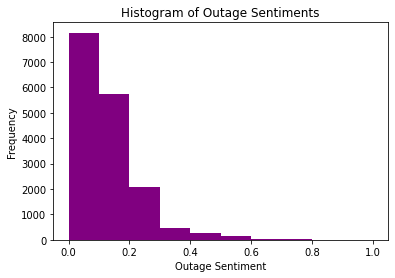

In [440]:
plt.hist(sent_df['outage_sentiment'],color='purple')
plt.title('Histogram of Outage Sentiments')
plt.xlabel('Outage Sentiment')
plt.ylabel('Frequency');

Right skewed, peak of data near 0. Majority of data has low outage sentiment meaning a low association with power outages. 

In [441]:
# adding 1 to each value to be able to log
sent_1 = [i+1 for i in sentiments]

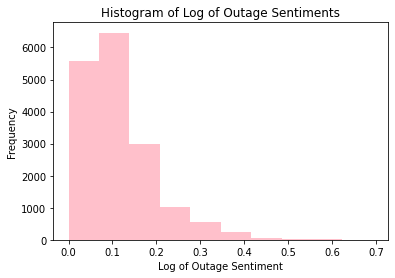

In [442]:
plt.hist(np.log(sent_1),color='pink')
plt.title('Histogram of Log of Outage Sentiments')
plt.xlabel('Log of Outage Sentiment')
plt.ylabel('Frequency');

Taking the log of the values did not normalize it ... hm

In [450]:
tweets.insert(11,column = 'outage_sentiment', value=sentiments, allow_duplicates=False)

In [451]:
tweets.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,name_and_tweet,outage_sentiment
0,710245730590404608,ttwn sf bay area,power outage in cupertino bayarea traffic,2016-03-16 23:25:52,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,ttwn sf bay area power outage in cupertino bay...,0.33
1,708811502241734656,san jose now,weather alert flash flood watch in bay area am...,2016-03-13 00:26:45,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now weather alert flash flood watch i...,0.25
2,706856719733776384,san jose now,power outages in san francisco on peninsula in...,2016-03-07 14:59:09,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now power outages in san francisco on...,0.18
3,726876023573204993,san jose now,power outage in fremont several intersections ...,2016-05-01 20:48:43,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now power outage in fremont several i...,0.23
4,724681945095888897,san jose now,east bay power outages also affects bart uc be...,2016-04-25 19:30:14,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now east bay power outages also affec...,0.20


In [452]:
tweets.to_csv('../data/cleaned_tweets.csv')